In [1]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "04_detect_segment/04ac_retinanet_arthropods_predict.ipynb" # change to reflect your notebook
_nb_title = "Object Detection with RetinaNet on Arthropods dataset / inference" # change to reflect your notebook
_nb_message = "This notebook allows you to test reading from the Arthropods dataset in TFRecord format, loading a trained model and running it on sample data" # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Object+Detection+with+RetinaNet+on+Arthropods+dataset+%2F+inference&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_detect_segment%2F04ac_retinanet_arthropods_predict.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_detect_segment/04ac_retinanet_arthropods_predict.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_detect_segment/04ac_retinanet_arthropods_predict.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_detect_segment/04ac_retinanet_arthropods_predict.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Object Detection with RetinaNet on Arthropods dataset / inference</h1>This notebook allows you to test reading from the Arthropods dataset in TFRecord format, loading a trained model and running it on sample data

In [2]:
import tensorflow as tf
import numpy as np
import os, re, math
from matplotlib import pyplot as plt
import matplotlib as mpl
import utils_box as box
AUTO = tf.data.AUTOTUNE

# Data source configuration

In [3]:
# load the test files only
DATA_PATH_PATTERN = 'gs://practical-ml-vision-book/arthropod_detection_tfr/size_w1024px/*test.tfrec'

RAW_CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera',
               '_truncated', '_blurred', '_occluded', ]
CLASSES = [klass for klass in RAW_CLASSES if klass not in ['_truncated', '_blurred', '_occluded', ]]

# Lepidoptera = butterfies and moths
# Hymenoptera = wasps, bees and ants
# Hemiptera = true bugs (cicadas, aphids, shield bugs, ...)
# Odonata = dragonflies
# Diptera = fies
# Araneae = spiders
# Coleoptera = beetles

# NOT IN DATASET
# Orthoptera = grasshoppers

# Display utilities

In [4]:
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

def display_detections(images, offsets, resizes, detections, classnames, ground_truth_boxes=[]):
    # scale and offset the detected boxes back to original image coordinates
    boxes   = [[ (x,y,w,h)  for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    boxes   = [[ (x-ofs[1], y-ofs[0], w, h) for x,y,w,h in boxlist ] for boxlist, ofs in zip(boxes, offsets)]
    boxes   = [[ (x*rsz, y*rsz, w*rsz, h*rsz) for x,y,w,h in boxlist ] for boxlist, rsz in zip(boxes, resizes)]
    classes = [[ int(klass) for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    scores  = [[ score      for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes)
    
    
# images, boxes and classes must have the same number of elements
# scores can be en empty list []. If it is not empty, it must also
# have the same number of elements.
# classnames is the list of possible classes (strings)
def display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes=[]):
    N = len(images)
    sqrtN = int(math.ceil(math.sqrt(N)))
    aspect = sum([im.shape[1]/im.shape[0] for im in images])/len(images) # mean aspect ratio of images
    fig = plt.figure(figsize=(15,15/aspect), frameon=False)
    
    for k in range(N):
        ax = plt.subplot(sqrtN, sqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])
        
        if ground_truth_boxes:
            for box in ground_truth_boxes[k]:
                x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
                #x, y, w, h = (box[0], box[1], box[2], box[3])
                rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#FFFFFFA0',facecolor='none')
                ax.add_patch(rect)

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
            x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
            #x, y, w, h = (box[0], box[1], box[2], box[3])
            #label = classnames[klass-1] # predicted classes are 1-based
            label = classnames[klass]
            if scores:
                label += ' ' + str(int(scores[k][i]*100)) + '%' 
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#00000080',facecolor='none')
            ax.add_patch(rect)
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=2,edgecolor='#FFFF00FF',facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#00000080', fc='#0000004E', linewidth=3) )
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#FFFF00FF', fc='#0000004E', linewidth=1.5) )
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

# Load Dataset from TFRecords

In [5]:
def read_tfrecord(example):
    feature = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string), # compressed image bytes
        "image/source_id": tf.io.FixedLenFeature([], tf.string),  # string
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
        "image/object/class/label": tf.io.VarLenFeature(tf.int64) # one tag per box
    }
    example = tf.io.parse_single_example(example, feature)
    source_id = example['image/source_id']
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    boxes_xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    boxes_xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    boxes_ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    boxes_ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    boxes = tf.stack([boxes_xmin, boxes_ymin, boxes_xmax, boxes_ymax], axis=-1)
    labels = tf.sparse.to_dense(example['image/object/class/label'])
    return image, source_id, boxes, labels
    
def load_tfrecord_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [6]:
filenames = tf.io.gfile.glob(DATA_PATH_PATTERN)
print(f"Found {len(filenames)} TFRecord files.")
print(f"{count_data_items(filenames)} images")

dataset = load_tfrecord_dataset(filenames)
dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(4))
dataset_iterator = iter(dataset)

Found 8 TFRecord files.
3832 images


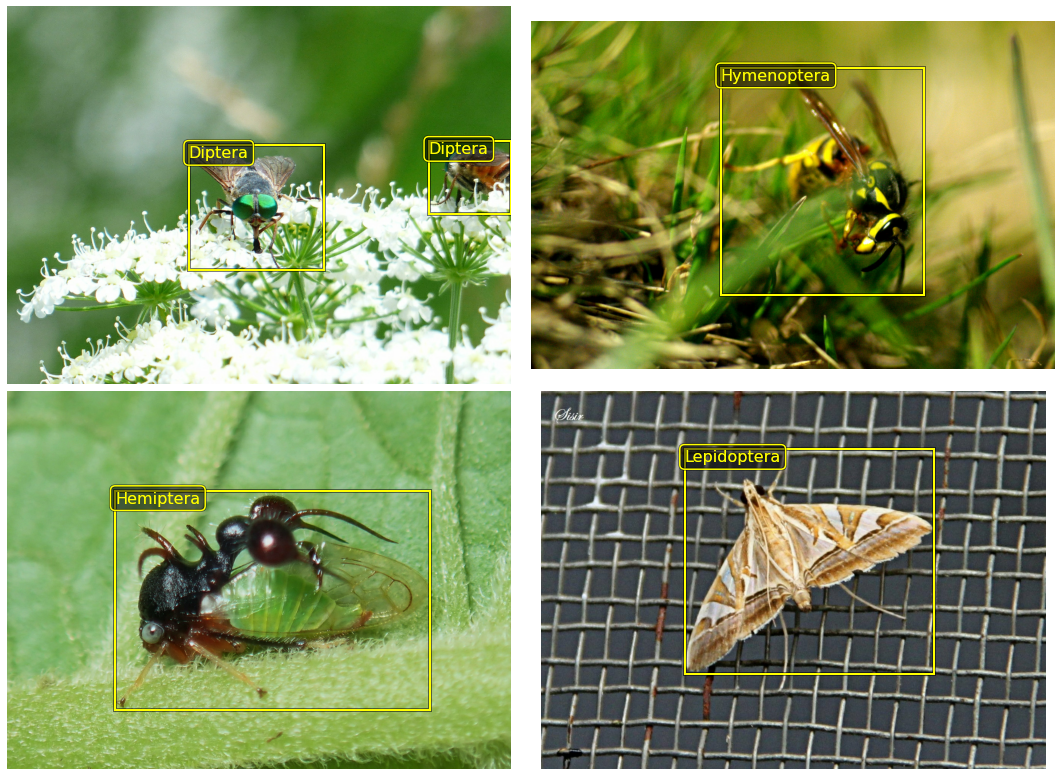

In [7]:
# run this cell  multiple times to obtain new images

images, source_id, boxes, labels = next(dataset_iterator)
images = [im.numpy() for im in images] # must do this for ragged

# must scale the rois back to pixels for visualizatoin
image_shapes = [tf.cast((image.shape[1], image.shape[0]), tf.float32) for image in images]
boxes = [box.scale_rois(bbox, image_shapes[i]) for i,bbox in enumerate(boxes)]

# must shift labels back to 0-based for visualization
labels -= 1 
#classes = [[CLASSES.index(label) for label in batchitem] for batchitem in labels]
display_with_boxes(images, boxes, labels, None, CLASSES, ground_truth_boxes=[])

# Load a trained model

In [ ]:
# Set the path to your own trained model here
MODEL_DIR = "gs://practical-ml-vision-book/arthropod_detection_tfr/trained_saved_model_AP50_0.689_job1625833840/"
restored_model = tf.saved_model.load(MODEL_DIR)

# Resize images and boxes to 384x384 for inference

In [10]:
TARGET_SIZE = [384,384]

# Returns two crop_boxes. The first is the preferred crop box,
# the second one is an alternative.
# output format: x1 y1 x2 y2 in relative image coordinates
def compute_crop_boxes(image_size, target_aspect_ratio):
    W = image_size[1]
    w = target_aspect_ratio[1]
    H = image_size[0]
    h = target_aspect_ratio[0]
    # box with desired aspect ration that fits in the image horizontally
    crop_box1 = [0.0, (1-W/w*h/H)/2.0, 1.0, (1+W/w*h/H)/2.0] # format x1 y1 x2 y2
    # box with desired aspect ration that fits in the image vertically
    crop_box2 = [(1-w/W*H/h)/2.0, 0.0, (1+w/W*H/h)/2.0, 1.0] # format x1 y1 x2 y2
    # select the box that crops the image, not the one that adds black borders
    return tf.cond(crop_box1[1]>0, lambda:(crop_box1, crop_box2), lambda:(crop_box2, crop_box1))

# Resize images to TARGET_SIZE. Crop if necessary and if cropping does not cut any
# bounding boxes. Pad otherwise. This must be run without batching.
def resize_and_crop_image_and_boxes(im, source_id, boxes, labels):
    image_size = tf.cast(tf.shape(im)[0:2], tf.float32)
    # boxes back to image coordinates
    boxes = box.scale_rois(boxes, image_size)
    crop_boxes = compute_crop_boxes(image_size, TARGET_SIZE)
    
    # select the cropping method so as not to lose any bounding box
    tiles = box.scale_rois(crop_boxes, image_size) # convert to absolute image coordinates
    _, is_roi_in_tile = box.find_fully_intersecting_rois(tiles, boxes) # [n_tiles, n_rois]
    crop_box = tf.cond(tf.reduce_all(is_roi_in_tile[0]), lambda: crop_boxes[0], lambda:crop_boxes[1])
    
    # resize image
    crop_box_for_tfimage = box.swap_xy(crop_box) # tf.image.crop_and_resize expects y1 x1 y2 x2 coordinates
    crop_box_for_tfimage = tf.expand_dims(crop_box_for_tfimage, axis=0) # tf.image.crop_and_resize expects a list of boxes
    box_indices = tf.zeros([1], tf.int32) # all boxes refer to the same image
    images = tf.expand_dims(im, axis=0) # tf.image.crop_and_resize expects a batch of images
    images = tf.image.crop_and_resize(images, crop_box_for_tfimage, box_indices, [TARGET_SIZE[1], TARGET_SIZE[0]])
    im = tf.cast(tf.squeeze(images, axis=0), tf.uint8)
    
    # resize boxes
    tiles = box.scale_rois(crop_box, image_size) # convert to absolute image coordinates
    tiles = tf.expand_dims(tiles, axis=0) # box.rois_in_tiles_relative expects a list of tiles (we have one)
    boxes, is_box_in_tile = box.rois_in_tiles_relative(tiles, boxes)
    boxes = tf.squeeze(boxes, axis=0) # we have only one crop tile
    boxes = box.scale_rois(boxes, tf.cast(TARGET_SIZE, tf.float32))
    #boxes = tf.cast(tf.round(boxes), tf.int32)
    
    # assert fail when losing boxes dues to cropping (not implemented)
    assert_op = tf.debugging.assert_equal(tf.reduce_all(is_box_in_tile), True, message=
        "Cropping causes boxes to fall outside of the image. The code for properly "
        "removing these boxes and their associated classes is not written so you cannot do that.")
    with tf.control_dependencies([assert_op]):
         boxes = tf.identity(boxes)
    
    return im, source_id, boxes, labels

In [12]:
dataset = load_tfrecord_dataset(filenames)
dataset = dataset.map(resize_and_crop_image_and_boxes)
dataset = dataset.shuffle(100)
dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(4))
dataset_iterator = iter(dataset)

# Sample images and inference

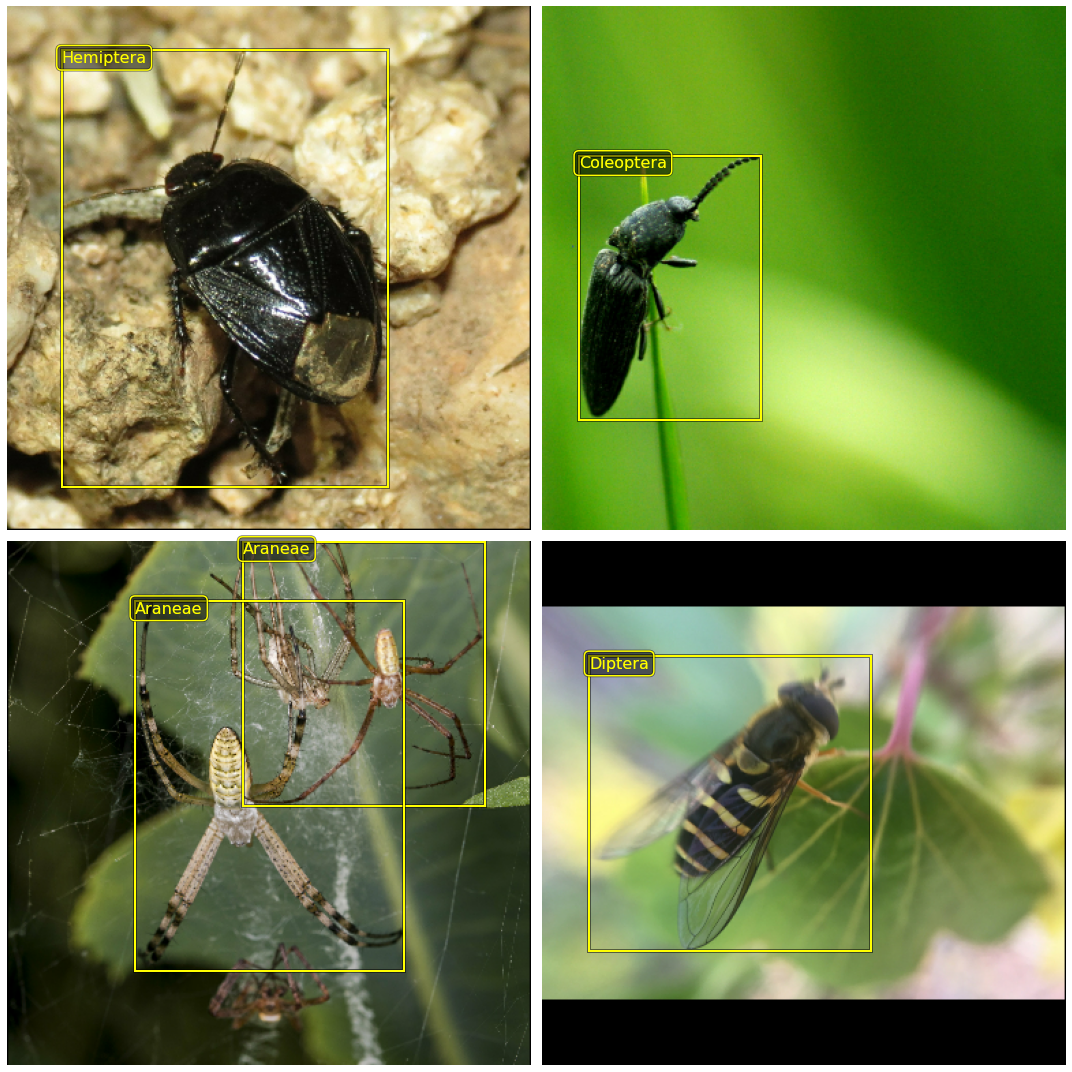

In [56]:
# you can run this entire section multiple times to load and predict on new images

# sample images
image_tensor, source_ids, ground_truth_boxes, labels = next(dataset_iterator)
images = [im.numpy() for im in image_tensor] # must do this for ragged

# must shift labels back to 0-based for visualization
labels -= 1 
display_with_boxes(images, ground_truth_boxes, labels, None, CLASSES, ground_truth_boxes=[])

In [57]:
# runnig the model
detections = restored_model.signatures['serving_default'](inputs=image_tensor)

SCORE_TRESHOLD = 0.3
all_boxes=[]
all_classes=[]
all_scores=[]
all_gtboxes=[]
for i, (boxes, classes, scores, _) in enumerate(zip(detections['detection_boxes'],
                                                    detections['detection_classes'],
                                                    detections['detection_scores'],
                                                    detections['num_detections'])):
    
    # reversing order because the model tends to return the most probable detections last, while I want them displayed on top
    # swapping x,y in boxes because the Model Garden standard is y,x while the display code uses x,y
    
    boxes2 = [box.swap_xy(bbox) for i,bbox in reversed(list(enumerate(boxes))) if scores[i]>SCORE_TRESHOLD]
    classes2 = [lbl-1 for i,lbl in reversed(list(enumerate(classes.numpy()))) if scores[i]>SCORE_TRESHOLD]
    scores2 = [scr for scr in reversed(scores.numpy()) if scr>SCORE_TRESHOLD]
    gt_boxes2 = [gtbox.numpy() for gtbox in ground_truth_boxes[i]] # must do this for ragged
    all_boxes.append(boxes2)
    all_classes.append(classes2)
    all_scores.append(scores2)
    all_gtboxes.append(gt_boxes2)

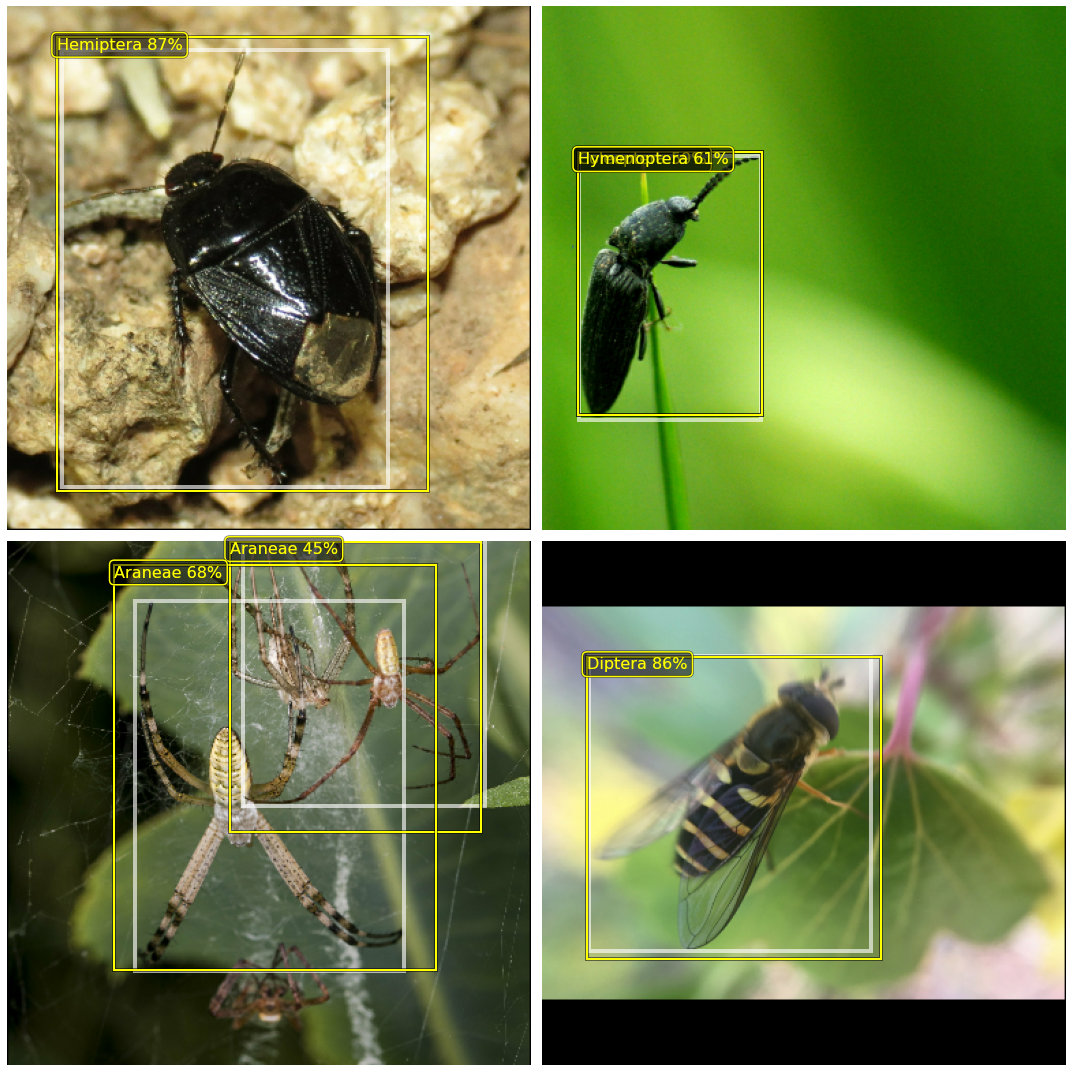

In [58]:
# display results (detection boxes in yellow, ground truth boxes in grey)
display_with_boxes(image_tensor, all_boxes, all_classes, all_scores, CLASSES, ground_truth_boxes=all_gtboxes)

## License
Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.